In [1]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import numpy as np

from scipy.stats import ttest_rel
from plotly.subplots import make_subplots
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sktime.transformations.series.detrend import STLTransformer

import pytz
import tqdm

In [2]:
def scatter_plot(df, x, y, title=''):
    df.plot.scatter(x=x, y=y, title=title)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

In [3]:
df_wti = pd.read_csv(
    './large_files/cl-1m.csv',
    sep=';', header=0,
    names=['date', 'time', 'open', 'high', 'low', 'close', 'volume']
)

df_wti['date'] = pd.to_datetime(df_wti['date'], format='%d/%m/%Y')
df_wti['date'] = df_wti['date'].dt.strftime('%m-%d-%Y')

df_wti['datetime'] = pd.to_datetime(df_wti['date'] + ' ' + df_wti['time'])

df_wti['datetime'] = df_wti['datetime'].dt.tz_localize('Etc/GMT+6')
ny_tz = pytz.timezone('America/New_York')
df_wti['datetime'] = df_wti['datetime'].dt.tz_convert(ny_tz)
df_wti['datetime'] = pd.to_datetime(df_wti['datetime'])
df_wti['date'] = df_wti['datetime'].dt.strftime('%Y-%m-%d')
df_wti['time'] = df_wti['datetime'].dt.strftime('%H%M')
df_wti['day'] = df_wti['datetime'].dt.strftime('%A')

# take only wednesday data for 10 years
df_wti = df_wti[(df_wti['datetime'].dt.hour >= 9) & (df_wti['datetime'].dt.hour < 16)]
df = df_wti[(df_wti['datetime'].dt.weekday == 2) & (df_wti['datetime'].dt.year >= 2010) & (df_wti['datetime'].dt.year <= 2019)]
df.head()

,date,time,open,high,low,close,volume,datetime,day
834878,2010-01-06,0900,81.84,81.90,81.82,81.83,748,2010-01-06 09:00:00-05:00,Wednesday
834879,2010-01-06,0901,81.84,81.87,81.76,81.78,554,2010-01-06 09:01:00-05:00,Wednesday
834880,2010-01-06,0902,81.78,81.80,81.76,81.78,182,2010-01-06 09:02:00-05:00,Wednesday
834881,2010-01-06,0903,81.78,81.82,81.77,81.79,206,2010-01-06 09:03:00-05:00,Wednesday
834882,2010-01-06,0904,81.80,81.80,81.75,81.78,298,2010-01-06 09:04:00-05:00,Wednesday


In [4]:
nine_thirty = pd.to_datetime('09:30:00')
ten_thirty = pd.to_datetime('10:30:00')
eleven_thirty = pd.to_datetime('11:30:00')

df_result = []
for day, df_day in tqdm.tqdm(df.groupby(pd.Grouper(key='datetime', freq='D'))):
    # 1030
    df_1030 = df_day[df_day['datetime'].dt.time == ten_thirty.time()]

    # the grouper function will generate every day sequentially even if
    # it is not in dataframe
    if (df_1030.shape[0] == 0) or (day.strftime('%A') != 'Wednesday'):
        continue
    price = df_1030['close'].values[0]

    # past hour
    df_past = df_day[
        (df_day['datetime'].dt.time >= nine_thirty.time()) &
        (df_day['datetime'].dt.time < ten_thirty.time())
    ]
    past_mean = df_past['close'].mean()
    past_std = df_past['close'].std()
    z_past = (price - past_mean) / past_std

    # next hour
    df_next = df_day[
        (df_day['datetime'].dt.time >= ten_thirty.time()) &
        (df_day['datetime'].dt.time < eleven_thirty.time())
    ]

    # compute z_score of 1030 price relative to mean of next hour
    next_mean = df_next['close'].mean()
    next_std = df_next['close'].std()
    z_next = (price - next_mean) / next_std

    # z score of next hour mean compared to past hour
    z_next_mean = (next_mean - past_mean) / past_std

    result = {
        'date': df_1030['datetime'].iloc[0],
        '1030_close': price,
        'z_past': z_past,
        'z_next': z_next,
        'past_mean': past_mean,
        'next_mean': next_mean,
        'z_next_mean': z_next_mean
    }
    df_result.append(result)

df_result = pd.DataFrame(df_result)
df_result.head(10)

100%|██████████| 3634/3634 [00:01<00:00, 1916.11it/s]


,date,1030_close,z_past,z_next,past_mean,next_mean,z_next_mean
0,2010-01-06 10:30:00-05:00,81.50,-2.909408,-0.102162,81.819333,81.544167,-2.507011
1,2010-01-13 10:30:00-05:00,78.44,-4.694694,-2.364913,79.620667,78.988500,-2.513689
2,2010-01-20 10:30:00-05:00,77.39,-2.263481,-1.011904,77.845667,77.490000,-1.766740
3,2010-01-27 10:30:00-05:00,74.53,0.053073,0.075339,74.522000,74.507167,-0.098406
4,2010-02-03 10:30:00-05:00,77.39,0.780636,-0.164798,77.314500,77.435500,1.251086
5,2010-02-10 10:30:00-05:00,72.76,-1.830737,-1.095081,73.394828,72.889500,-1.457281
6,2010-02-17 10:30:00-05:00,77.04,-1.373332,1.254065,77.184667,76.880000,-2.892224
7,2010-02-24 10:30:00-05:00,78.50,-3.076658,-2.828870,79.051500,79.521667,2.622923
8,2010-03-03 10:30:00-05:00,79.64,-8.400082,-2.217377,80.230333,80.477833,3.521773
9,2010-03-10 10:30:00-05:00,81.83,8.945147,-1.882707,81.367500,82.524667,22.380596


- z_past: how far the price at 1030 hours deviates from the mean price observed in the past hour
- z_next: how far the price at 1030 hours deviates from the mean price observed in the next hour
- z_next_mean: how far the mean price of 1030 - 1130 deviates from the mean price observed in 0930 to 1030

In [5]:
df_result.describe()

,1030_close,z_past,z_next,past_mean,next_mean,z_next_mean
count,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000
mean,72.459151,-0.022384,-0.114592,72.463533,72.478650,0.200403
std,21.890600,2.149211,1.499870,21.899697,21.876422,3.612622
min,28.450000,-9.867332,-4.666017,27.786000,28.075333,-21.529199
25%,52.352500,-1.224224,-1.244041,52.402417,52.450333,-1.713577
50%,71.500000,0.112336,-0.144313,71.349500,71.696000,0.314045
75%,93.622500,1.265299,1.053881,93.521542,93.391542,1.985651
max,112.210000,9.951940,4.706697,112.334500,111.958333,22.380596


past_mean:  ShapiroResult(statistic=0.9317326545715332, pvalue=1.246443540828951e-14)
next_mean:  ShapiroResult(statistic=0.9310953617095947, pvalue=1.0477975434454619e-14)


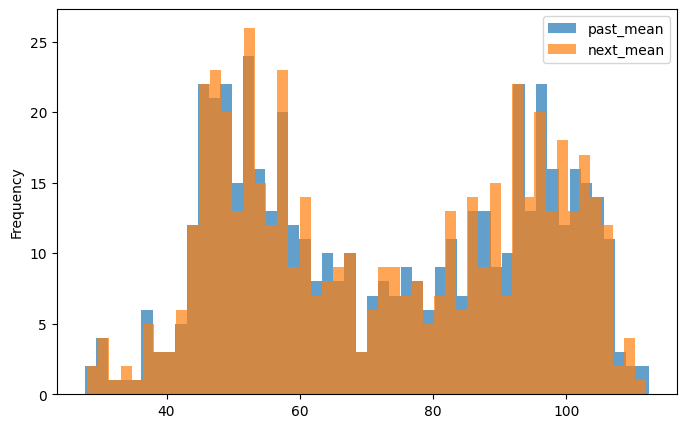

In [6]:
print('past_mean: ', stats.shapiro(df_result['past_mean']))
print('next_mean: ', stats.shapiro(df_result['next_mean']))

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
df_result['past_mean'].plot.hist(bins=50, ax=ax, alpha=0.7, label='past_mean')
df_result['next_mean'].plot.hist(bins=50, ax=ax, alpha=0.7, label='next_mean')
plt.legend()

In [7]:
# NOT THE CORRECT TEST as data is not normal

# null hypothesis: mean difference = 0
# alt hypothesis: means are significantly different, higher or lower
stats.ttest_rel(df_result['past_mean'], df_result['next_mean'], alternative='two-sided')

TtestResult(statistic=-0.9042094736929782, pvalue=0.3663054733382569, df=517)

In [8]:
stats.wilcoxon(df_result['past_mean'], df_result['next_mean'])

WilcoxonResult(statistic=62642.5, pvalue=0.18015607080844565)

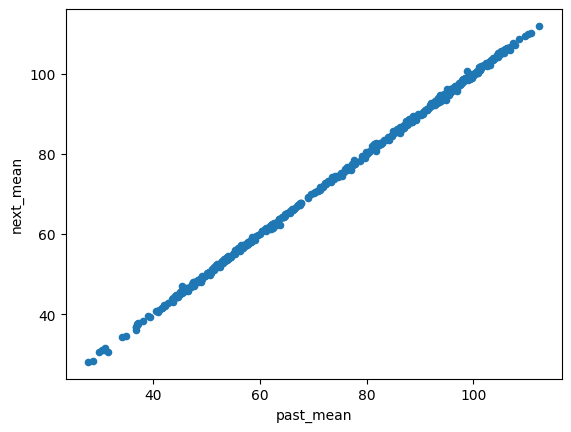

In [9]:
scatter_plot(df_result, 'past_mean', 'next_mean')

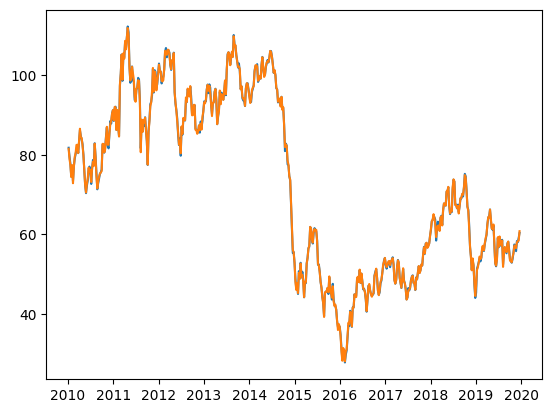

In [10]:
plt.plot(df_result['date'].dt.date, df_result['past_mean'], label='last hour')
plt.plot(df_result['date'].dt.date, df_result['next_mean'], label='next hour')
plt.show()

Correlation between the deviation of price at 1030 to past hour and the deviation of price at 1030 to next hour 

z_past:  ShapiroResult(statistic=0.9501423835754395, pvalue=3.3102064925932817e-12)
z_next:  ShapiroResult(statistic=0.9917218685150146, pvalue=0.0055027129128575325)


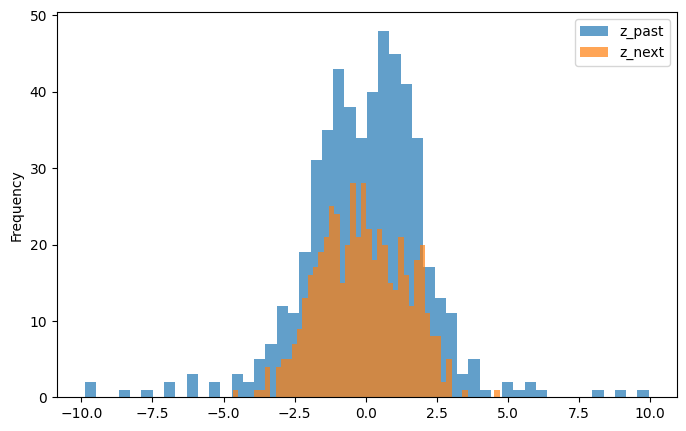

In [11]:
print('z_past: ', stats.shapiro(df_result['z_past']))
print('z_next: ', stats.shapiro(df_result['z_next']))

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
df_result['z_past'].plot.hist(bins=50, ax=ax, alpha=0.7, label='z_past')
df_result['z_next'].plot.hist(bins=50, ax=ax, alpha=0.7, label='z_next')
plt.legend()

In [12]:
stats.ttest_rel(df_result['z_past'], df_result['z_next'], alternative='two-sided')

TtestResult(statistic=0.7922675398387654, pvalue=0.42856807051552204, df=517)

In [13]:
stats.wilcoxon(df_result['z_past'], df_result['z_next'], alternative='two-sided')

WilcoxonResult(statistic=63032.0, pvalue=0.22020120317144254)

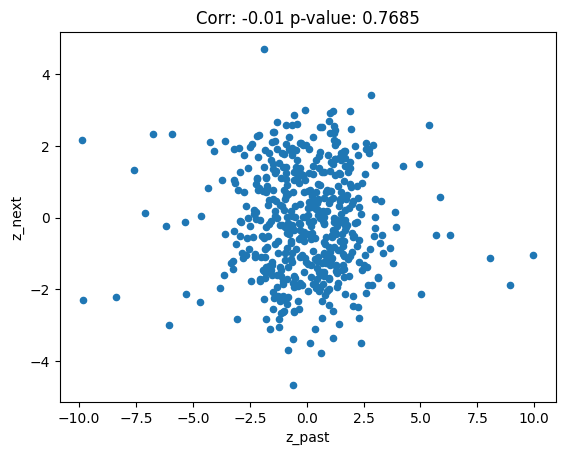

In [14]:
correlation, pvalue = spearmanr(df_result['z_past'], df_result['z_next'])
scatter_plot(df_result, 'z_past', 'z_next', f'Corr: {correlation:.2f} p-value: {pvalue:.4f}')

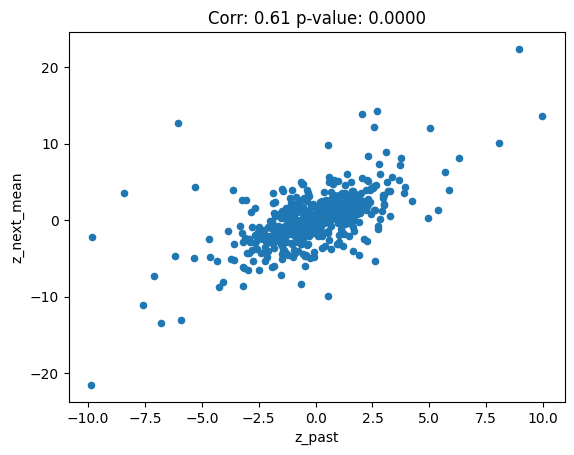

In [15]:
correlation, pvalue = spearmanr(df_result['z_past'], df_result['z_next_mean'])
scatter_plot(df_result, 'z_past', 'z_next_mean', f'Corr: {correlation:.2f} p-value: {pvalue:.4f}')

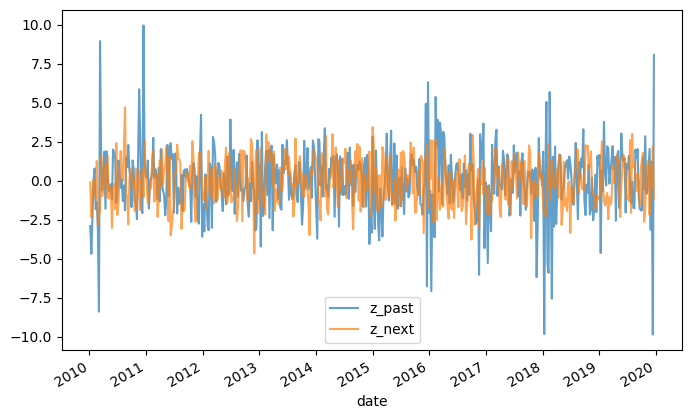

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
df_result.plot.line(x='date', y='z_past', ax=ax, alpha=0.7, label='z_past')
df_result.plot.line(x='date', y='z_next', ax=ax, alpha=0.7, label='z_next')
plt.legend()

Retry with comparing to 1130 - 1230

In [17]:
nine_thirty = pd.to_datetime('09:30:00')
ten_thirty = pd.to_datetime('10:30:00')
eleven_thirty = pd.to_datetime('11:30:00')
twelve_thirty = pd.to_datetime('12:30:00')

df_result = []
for day, df_day in tqdm.tqdm(df.groupby(pd.Grouper(key='datetime', freq='D'))):
    # 1030
    df_1030 = df_day[df_day['datetime'].dt.time == ten_thirty.time()]

    # the grouper function will generate every day sequentially even if
    # it is not in dataframe
    if (df_1030.shape[0] == 0) or (day.strftime('%A') != 'Wednesday'):
        continue
    price = df_1030['close'].values[0]

    # past hour
    df_past = df_day[
        (df_day['datetime'].dt.time >= nine_thirty.time()) &
        (df_day['datetime'].dt.time < ten_thirty.time())
    ]
    past_mean = df_past['close'].mean()
    past_std = df_past['close'].std()
    z_past = (price - past_mean) / past_std

    # next hour
    df_next = df_day[
        (df_day['datetime'].dt.time >= eleven_thirty.time()) &
        (df_day['datetime'].dt.time < twelve_thirty.time())
    ]

    # compute z_score of 1030 price relative to mean of next hour
    next_mean = df_next['close'].mean()
    next_std = df_next['close'].std()
    z_next = (price - next_mean) / next_std

    result = {
        'date': df_1030['datetime'].iloc[0],
        '1030_close': price,
        'z_past': z_past,
        'z_next': z_next,
        'past_mean': past_mean,
        'next_mean': next_mean
    }
    df_result.append(result)

df_result = pd.DataFrame(df_result)
display(df_result.head())

100%|██████████| 3634/3634 [00:01<00:00, 1839.19it/s]


,date,1030_close,z_past,z_next,past_mean,next_mean
0,2010-01-06 10:30:00-05:00,81.50,-2.909408,-7.093289,81.819333,82.731000
1,2010-01-13 10:30:00-05:00,78.44,-4.694694,-5.340946,79.620667,79.669833
2,2010-01-20 10:30:00-05:00,77.39,-2.263481,-1.847691,77.845667,77.615000
3,2010-01-27 10:30:00-05:00,74.53,0.053073,-2.073317,74.522000,74.741833
4,2010-02-03 10:30:00-05:00,77.39,0.780636,1.674273,77.314500,77.110333


In [18]:
df_result.describe()

,1030_close,z_past,z_next,past_mean,next_mean
count,518.000000,518.000000,518.000000,518.000000,518.000000
mean,72.459151,-0.022384,-0.092225,72.463533,72.481156
std,21.890600,2.149211,4.469192,21.899697,21.879130
min,28.450000,-9.867332,-17.755059,27.786000,27.835000
25%,52.352500,-1.224224,-2.369721,52.402417,52.208083
50%,71.500000,0.112336,-0.144181,71.349500,71.342333
75%,93.622500,1.265299,2.535407,93.521542,93.827292
max,112.210000,9.951940,17.320733,112.334500,111.566833


past_mean:  ShapiroResult(statistic=0.9317326545715332, pvalue=1.246443540828951e-14)
next_mean:  ShapiroResult(statistic=0.9310840964317322, pvalue=1.0445990623333349e-14)


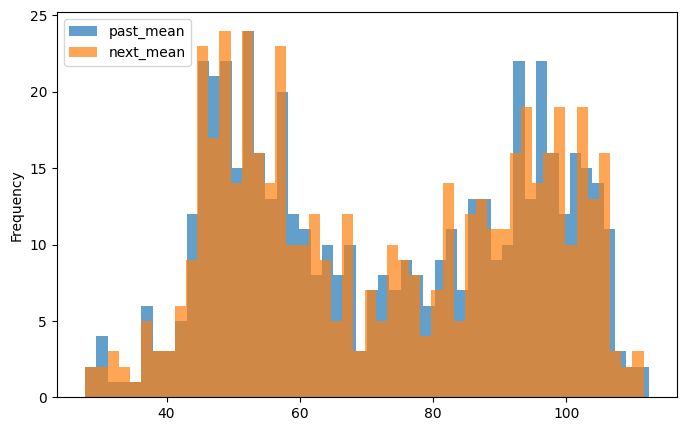

In [19]:
print('past_mean: ', stats.shapiro(df_result['past_mean']))
print('next_mean: ', stats.shapiro(df_result['next_mean']))

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
df_result['past_mean'].plot.hist(bins=50, ax=ax, alpha=0.7, label='past_mean')
df_result['next_mean'].plot.hist(bins=50, ax=ax, alpha=0.7, label='next_mean')
plt.legend()

In [20]:
print(stats.ttest_rel(df_result['past_mean'], df_result['next_mean'], alternative='two-sided'))
print(stats.wilcoxon(df_result['past_mean'], df_result['next_mean'], alternative='two-sided'))

TtestResult(statistic=-0.5999376034941718, pvalue=0.5488106718338523, df=517)
WilcoxonResult(statistic=65474.5, pvalue=0.6105060115632177)


z_past:  ShapiroResult(statistic=0.9501423835754395, pvalue=3.3102064925932817e-12)
z_next:  ShapiroResult(statistic=0.9809613823890686, pvalue=2.7110140763397794e-06)


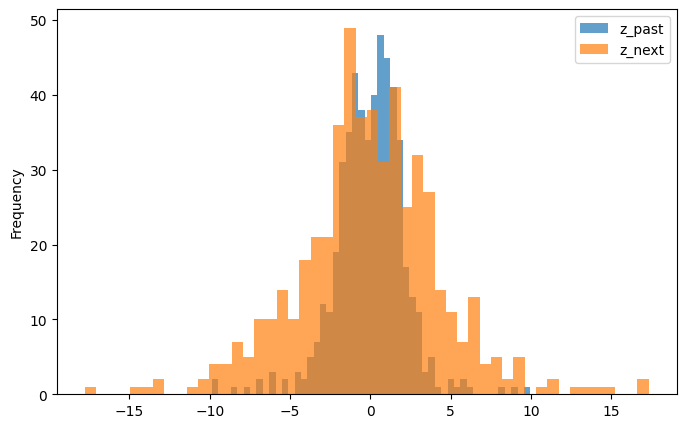

In [21]:
print('z_past: ', stats.shapiro(df_result['z_past']))
print('z_next: ', stats.shapiro(df_result['z_next']))

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
df_result['z_past'].plot.hist(bins=50, ax=ax, alpha=0.7, label='z_past')
df_result['z_next'].plot.hist(bins=50, ax=ax, alpha=0.7, label='z_next')
plt.legend()

Correlation between the deviation of price at 1030 to past half hour and the deviation of price at 1030 to next half hour 

In [22]:
ten = pd.to_datetime('10:00:00')
ten_thirty = pd.to_datetime('10:30:00')
eleven = pd.to_datetime('11:00:00')

df_result = []
for day, df_day in tqdm.tqdm(df.groupby(pd.Grouper(key='datetime', freq='D'))):
    # 1030
    df_1030 = df_day[df_day['datetime'].dt.time == ten_thirty.time()]

    # the grouper function will generate every day sequentially even if
    # it is not in dataframe
    if (df_1030.shape[0] == 0) or (day.strftime('%A') != 'Wednesday'):
        continue
    price = df_1030['close'].values[0]

    # past hour
    df_past = df_day[
        (df_day['datetime'].dt.time >= ten.time()) &
        (df_day['datetime'].dt.time < ten_thirty.time())
    ]
    past_mean = df_past['close'].mean()
    past_std = df_past['close'].std()
    z_past = (price - past_mean) / past_std

    # next hour
    df_next = df_day[
        (df_day['datetime'].dt.time >= ten_thirty.time()) &
        (df_day['datetime'].dt.time < eleven.time())
    ]

    # compute z_score of 1030 price relative to mean of next hour
    next_mean = df_next['close'].mean()
    next_std = df_next['close'].std()
    z_next = (price - next_mean) / next_std

    # z score of next hour mean compared to past hour
    z_next_mean = (next_mean - past_mean) / past_std

    result = {
        'date': df_1030['datetime'].iloc[0],
        '1030_close': price,
        'z_past': z_past,
        'z_next': z_next,
        'past_mean': past_mean,
        'next_mean': next_mean,
        'z_next_mean': z_next_mean
    }
    df_result.append(result)

df_result = pd.DataFrame(df_result)
df_result.head()

100%|██████████| 3634/3634 [00:02<00:00, 1803.77it/s]


,date,1030_close,z_past,z_next,past_mean,next_mean,z_next_mean
0,2010-01-06 10:30:00-05:00,81.50,-3.639029,2.251269,81.893000,81.220000,-6.231721
1,2010-01-13 10:30:00-05:00,78.44,-6.384144,-1.700912,79.402333,78.885333,-3.429791
2,2010-01-20 10:30:00-05:00,77.39,-1.902745,-1.046690,77.687667,77.453667,-1.495775
3,2010-01-27 10:30:00-05:00,74.53,1.110706,1.688189,74.408000,74.246667,-1.468803
4,2010-02-03 10:30:00-05:00,77.39,1.116174,0.755940,77.303667,77.221667,-1.060150


In [23]:
df_result.describe()

,1030_close,z_past,z_next,past_mean,next_mean,z_next_mean
count,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000
mean,72.459151,-0.048308,-0.085881,72.464625,72.471736,0.090771
std,21.890600,2.763518,1.469928,21.891305,21.884707,4.361597
min,28.450000,-13.226053,-3.379372,27.965000,28.254000,-31.588042
25%,52.352500,-1.433933,-1.219762,52.391250,52.498750,-1.815663
50%,71.500000,-0.020024,-0.194902,71.434167,71.645167,0.261633
75%,93.622500,1.157160,1.095096,93.483583,93.448000,2.093019
max,112.210000,16.299108,3.678061,112.444000,112.295000,24.022024


past_mean:  ShapiroResult(statistic=0.9316275119781494, pvalue=1.2111661432351144e-14)
next_mean:  ShapiroResult(statistic=0.9312199950218201, pvalue=1.0838876691521889e-14)


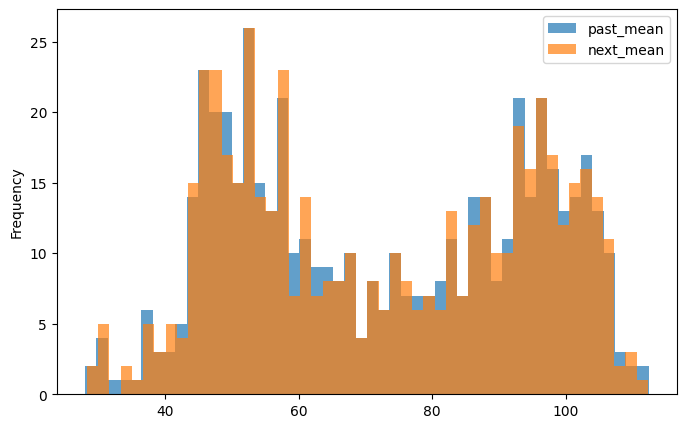

In [24]:
print('past_mean: ', stats.shapiro(df_result['past_mean']))
print('next_mean: ', stats.shapiro(df_result['next_mean']))

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
df_result['past_mean'].plot.hist(bins=50, ax=ax, alpha=0.7, label='past_mean')
df_result['next_mean'].plot.hist(bins=50, ax=ax, alpha=0.7, label='next_mean')
plt.legend()

z_past:  ShapiroResult(statistic=0.9069148302078247, pvalue=2.9097103750512314e-17)
z_next:  ShapiroResult(statistic=0.9849632978439331, pvalue=3.4514523576945066e-05)


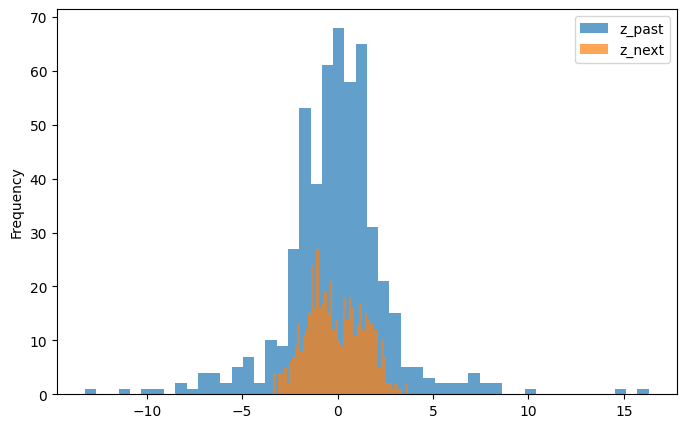

In [25]:
print('z_past: ', stats.shapiro(df_result['z_past']))
print('z_next: ', stats.shapiro(df_result['z_next']))

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
df_result['z_past'].plot.hist(bins=50, ax=ax, alpha=0.7, label='z_past')
df_result['z_next'].plot.hist(bins=50, ax=ax, alpha=0.7, label='z_next')
plt.legend()

In [26]:
print(stats.ttest_rel(df_result['z_past'], df_result['z_next'], alternative='two-sided'))
print(stats.wilcoxon(df_result['z_past'], df_result['z_next'], alternative='two-sided'))

TtestResult(statistic=0.2686453387183879, pvalue=0.7883097833730338, df=517)
WilcoxonResult(statistic=65643.0, pvalue=0.645579012433209)


In [27]:
print(stats.ttest_rel(df_result['z_past'], df_result['z_next_mean'], alternative='two-sided'))
print(stats.wilcoxon(df_result['z_past'], df_result['z_next_mean'], alternative='two-sided'))

TtestResult(statistic=-1.0252242164736822, pvalue=0.3057368487886846, df=517)
WilcoxonResult(statistic=61522.0, pvalue=0.09511044193264198)


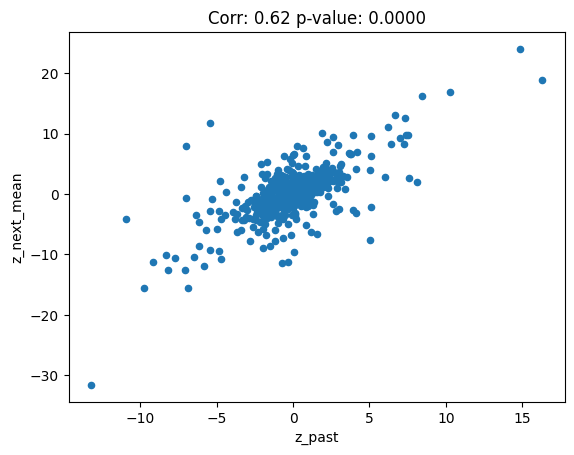

In [28]:
correlation, pvalue = spearmanr(df_result['z_past'], df_result['z_next_mean'])
scatter_plot(df_result, 'z_past', 'z_next_mean', f'Corr: {correlation:.2f} p-value: {pvalue:.4f}')

- Use mean of 1030 - 1100 as reference point

In [29]:
nine_thirty = pd.to_datetime('09:30:00')
ten_thirty = pd.to_datetime('10:30:00')
eleven = pd.to_datetime('11:00:00')
twelve = pd.to_datetime('12:00:00')

df_result = []
for day, df_day in tqdm.tqdm(df.groupby(pd.Grouper(key='datetime', freq='D'))):
    # 1030
    df_1030 = df_day[
        (df_day['datetime'].dt.time >= ten_thirty.time()) & \
        (df_day['datetime'].dt.time < eleven.time())
    ]

    # the grouper function will generate every day sequentially even if
    # it is not in dataframe
    if (df_1030.shape[0] == 0) or (day.strftime('%A') != 'Wednesday'):
        continue
    price = df_1030['close'].mean()

    # past hour
    df_past = df_day[
        (df_day['datetime'].dt.time >= nine_thirty.time()) &
        (df_day['datetime'].dt.time < ten_thirty.time())
    ]
    past_mean = df_past['close'].mean()
    past_std = df_past['close'].std()
    z_past = (price - past_mean) / past_std

    # next hour
    df_next = df_day[
        (df_day['datetime'].dt.time >= eleven.time()) &
        (df_day['datetime'].dt.time < twelve.time())
    ]

    # compute z_score of 1030 price relative to mean of next hour
    next_mean = df_next['close'].mean()
    next_std = df_next['close'].std()
    z_next = (price - next_mean) / next_std

    # z score of next hour mean compared to past hour
    z_next_mean = (next_mean - past_mean) / past_std

    result = {
        'date': df_1030['datetime'].iloc[0],
        '1030_mean_close': price,
        'z_past': z_past,
        'z_next': z_next,
        'past_mean': past_mean,
        'next_mean': next_mean,
        'z_next_mean': z_next_mean
    }
    df_result.append(result)

df_result = pd.DataFrame(df_result)
df_result.head(10)

  0%|          | 0/3634 [00:00<?, ?it/s]

100%|██████████| 3634/3634 [00:02<00:00, 1455.17it/s]


,date,1030_mean_close,z_past,z_next,past_mean,next_mean,z_next_mean
0,2010-01-06 10:30:00-05:00,81.220000,-5.460456,-1.988183,81.819333,82.321167,4.572145
1,2010-01-13 10:30:00-05:00,78.885333,-2.923912,-1.614973,79.620667,79.288167,-1.322122
2,2010-01-20 10:30:00-05:00,77.453667,-1.947223,-1.156704,77.845667,77.611667,-1.162373
3,2010-01-27 10:30:00-05:00,74.246667,-1.826592,-5.008001,74.522000,74.784500,1.741455
4,2010-02-03 10:30:00-05:00,77.221667,-0.959855,-0.564624,77.314500,77.393167,0.813378
5,2010-02-10 10:30:00-05:00,72.917000,-1.377975,-0.574963,73.394828,73.031167,-1.048738
6,2010-02-17 10:30:00-05:00,76.963333,-2.101135,1.910991,77.184667,76.763500,-3.998168
7,2010-02-24 10:30:00-05:00,79.270000,1.218948,-4.640874,79.051500,79.777167,4.048284
8,2010-03-03 10:30:00-05:00,80.165667,-0.920167,-4.716209,80.230333,80.880333,9.249102
9,2010-03-10 10:30:00-05:00,82.242000,16.913580,-1.211393,81.367500,82.589333,23.631305


In [30]:
df_result.describe()

,1030_mean_close,z_past,z_next,past_mean,next_mean,z_next_mean
count,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000
mean,72.471736,0.111583,-0.064148,72.463533,72.481854,0.213140
std,21.884707,3.185984,1.928573,21.899697,21.871237,4.960068
min,28.254000,-24.045735,-8.105203,27.786000,27.766667,-18.421461
25%,52.498750,-1.459493,-1.157180,52.402417,52.351375,-2.538982
50%,71.645167,0.308316,-0.130082,71.349500,71.504000,0.305314
75%,93.448000,1.665906,1.156607,93.521542,93.594792,2.901589
max,112.295000,16.913580,7.612075,112.334500,111.477667,23.631305


past_mean:  ShapiroResult(statistic=0.9317326545715332, pvalue=1.246443540828951e-14)
next_mean:  ShapiroResult(statistic=0.931003749370575, pvalue=1.0220602779365505e-14)


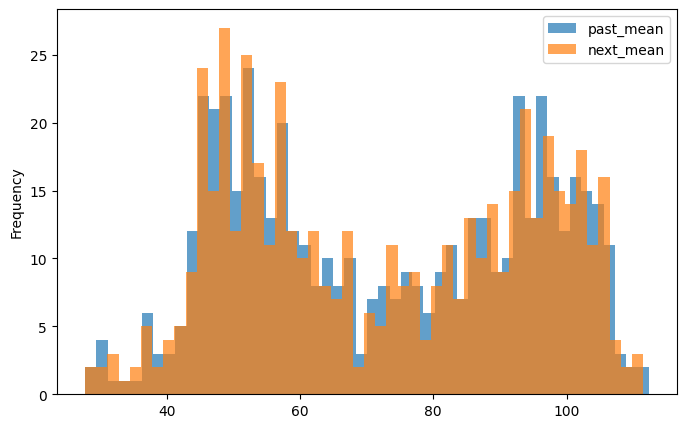

In [31]:
print('past_mean: ', stats.shapiro(df_result['past_mean']))
print('next_mean: ', stats.shapiro(df_result['next_mean']))

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
df_result['past_mean'].plot.hist(bins=50, ax=ax, alpha=0.7, label='past_mean')
df_result['next_mean'].plot.hist(bins=50, ax=ax, alpha=0.7, label='next_mean')
plt.legend()

z_past:  ShapiroResult(statistic=0.8980087041854858, pvalue=4.393298508334489e-18)
z_next:  ShapiroResult(statistic=0.9751331806182861, pvalue=1.0471918443499817e-07)


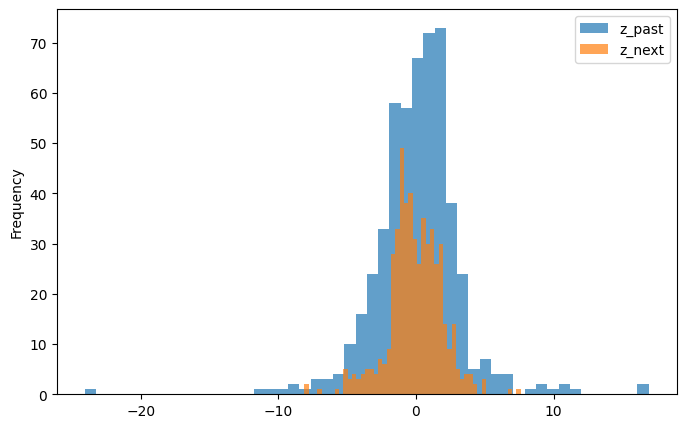

In [32]:
print('z_past: ', stats.shapiro(df_result['z_past']))
print('z_next: ', stats.shapiro(df_result['z_next']))

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
df_result['z_past'].plot.hist(bins=50, ax=ax, alpha=0.7, label='z_past')
df_result['z_next'].plot.hist(bins=50, ax=ax, alpha=0.7, label='z_next')
plt.legend()

In [33]:
print(stats.ttest_rel(df_result['z_past'], df_result['z_next'], alternative='two-sided'))
print(stats.wilcoxon(df_result['z_past'], df_result['z_next'], alternative='two-sided'))

TtestResult(statistic=1.0177459565173235, pvalue=0.3092747267790173, df=517)
WilcoxonResult(statistic=63476.0, pvalue=0.2732007103043014)


In [34]:
print(stats.ttest_rel(df_result['z_past'], df_result['z_next_mean'], alternative='two-sided'))
print(stats.wilcoxon(df_result['z_past'], df_result['z_next_mean'], alternative='two-sided'))

TtestResult(statistic=-0.6378246704168373, pvalue=0.5238702024518703, df=517)
WilcoxonResult(statistic=65693.0, pvalue=0.6561446859741095)


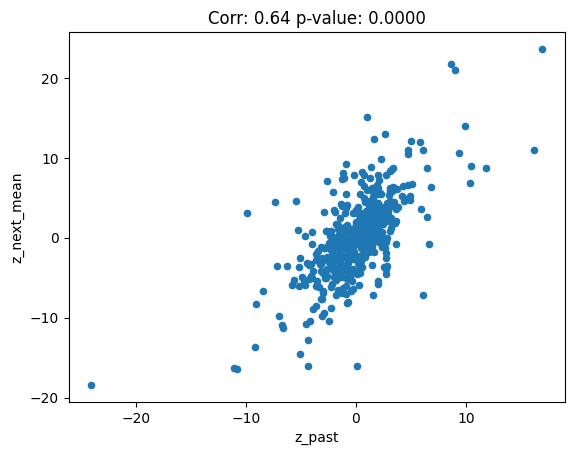

In [35]:
correlation, pvalue = spearmanr(df_result['z_past'], df_result['z_next_mean'])
scatter_plot(df_result, 'z_past', 'z_next_mean', f'Corr: {correlation:.2f} p-value: {pvalue:.4f}')

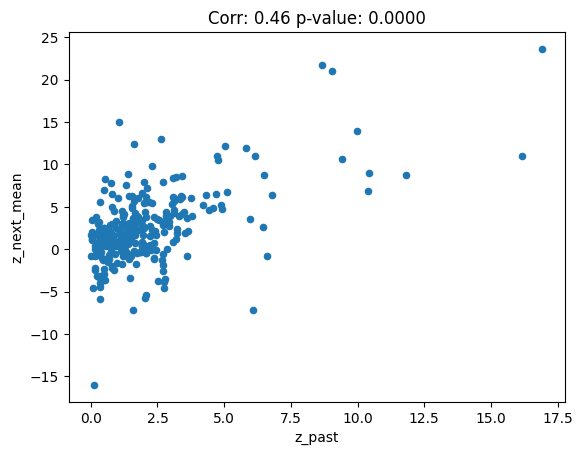

In [36]:
df_pos = df_result[df_result['z_past'] >= 0]
correlation, pvalue = spearmanr(df_pos['z_past'], df_pos['z_next_mean'])
scatter_plot(df_pos, 'z_past', 'z_next_mean', f'Corr: {correlation:.2f} p-value: {pvalue:.4f}')

z_past:  ShapiroResult(statistic=0.6911379098892212, pvalue=1.305843486921371e-22)
z_next:  ShapiroResult(statistic=0.9558038115501404, pvalue=1.231141908419886e-07)


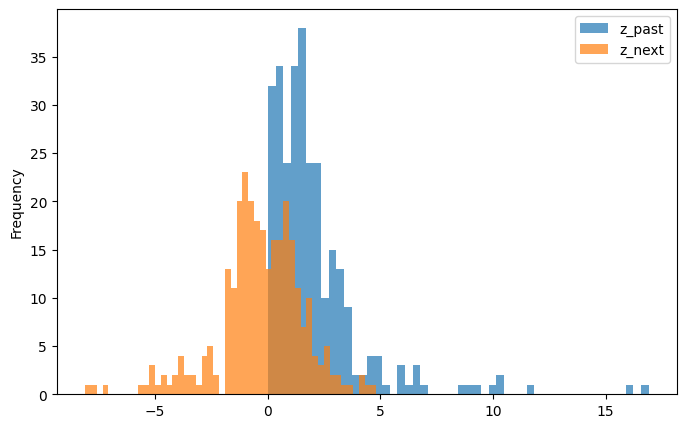

In [37]:
print('z_past: ', stats.shapiro(df_pos['z_past']))
print('z_next: ', stats.shapiro(df_pos['z_next']))

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
df_pos['z_past'].plot.hist(bins=50, ax=ax, alpha=0.7, label='z_past')
df_pos['z_next'].plot.hist(bins=50, ax=ax, alpha=0.7, label='z_next')
plt.legend()